In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [3]:
df_seattle = pd.read_csv("./bnb_data_seattle/listings.csv")
df_seattle.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [4]:
len(df_seattle.columns)

92

In [5]:
df_seattle.convert_dtypes().dtypes

id                                           Int64
listing_url                         string[python]
scrape_id                                    Int64
last_scraped                        string[python]
name                                string[python]
                                         ...      
cancellation_policy                 string[python]
require_guest_profile_picture       string[python]
require_guest_phone_verification    string[python]
calculated_host_listings_count               Int64
reviews_per_month                          Float64
Length: 92, dtype: object

In [6]:
df_cal = pd.read_csv("./bnb_data_seattle/calendar.csv")
# df_cal.head(3)

In [7]:
# date and price convertion helper functions

def get_year(row):    
    return row.dt.strftime("%Y")


def get_month(row):    
    return row.dt.strftime("%m")

def get_day(row):    
    return row.dt.strftime("%d")

def get_dollar(row):
    return row.replace('[$, ]', "", regex=True).astype(float)

# Questions:
    1) What are the factors that influence the price of Airbnb listings?
    
    2) Using listing descriptions, determine the neighborhood choice made by guests?

    3) What are the prices of listings in Seattle. By how much do prices spike? What are the maximum, minimum and mean price of the listings?
    
    4) Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

    5) Top 10 host with maximum number of bookings?

    6) Most expensive listings based on neighborhood?

In [8]:
set(df_seattle.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

# Q1: What are the factors that influence the price of Airbnb listings?

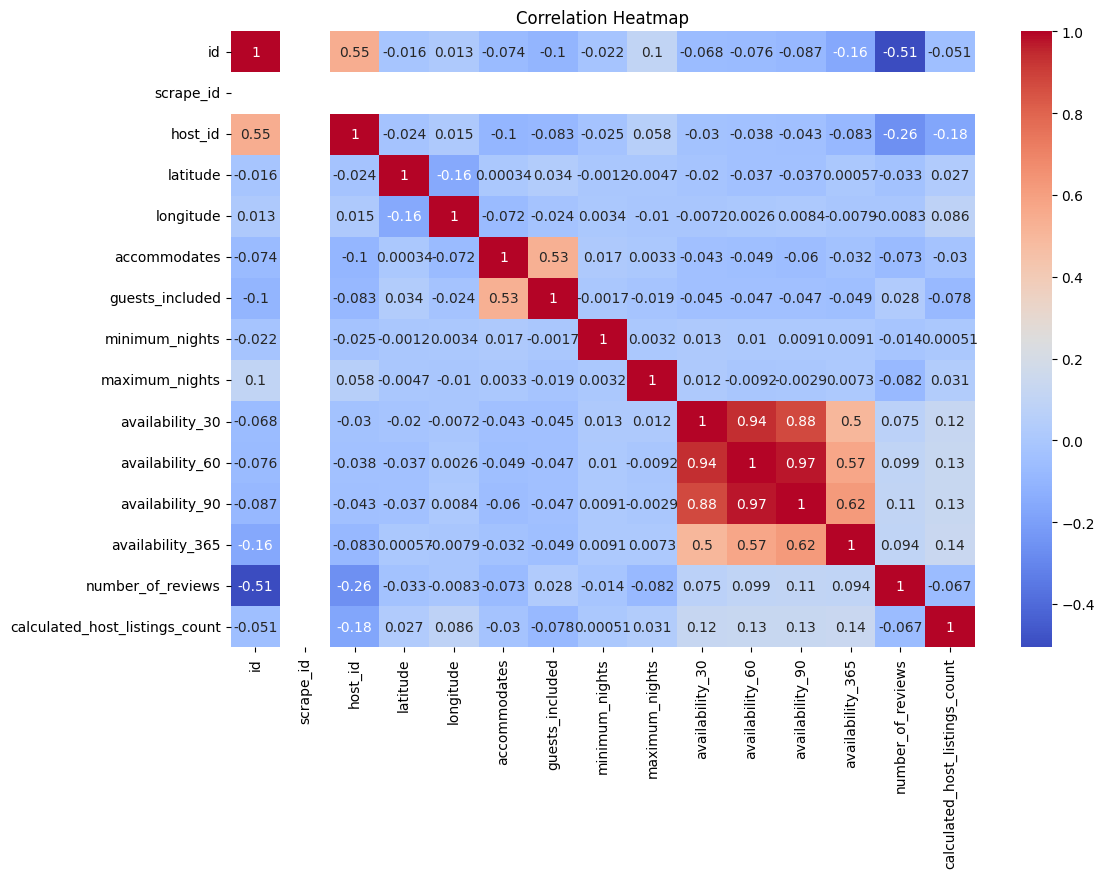

In [9]:
# Question 1: What are the factors that influence the price of Airbnb listings?
df1 = df_seattle.dropna(axis=1)

df_corr = df1.select_dtypes(['int64','float64'])

correlation = df_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

From the figure above we can deduce some of the major factors that have a high correlation are number of guests, number of guests a listing can accomadate. We see a high corealtion with availability as per the length of the stay for 30, 60 and 90 days.

The correlation heat map of Airbnb features provides valuable insights into the relationships between different variables in the dataset. From the figure above, we can deduce some of the major factors that have a high correlation.
One of the key correlations we observe is between the number of guests and the number of guests a listing can accommodate. This suggests that listings with a higher capacity tend to attract more guests, which makes intuitive sense.
Additionally, we notice a high correlation between availability and the length of stay for 30, 60, and 90 days. This implies that listings that are available for longer duration tend to have more availability for extended stays. This information can be useful for both hosts and guests who are interested in longer-term bookings.
By analyzing the correlation heat map, we can identify these significant correlations and use them to gain insights and make informed decisions. Understanding the relationships between different features can help us better understand the dynamics of the Airbnb market and potentially optimize pricing, availability, and other aspects of the listings.

In [10]:
# missing value counts
df_seattle.columns[(df_seattle.isnull().mean() > 0.5)] #.sort_values(ascending=False)

Index(['square_feet', 'monthly_price', 'security_deposit', 'license'], dtype='object')

# Q2: Using listing descriptions, determine the neighborhood choice made by guests?

In [11]:
sample_vals = df_seattle.neighborhood_overview.value_counts().reset_index()
print(sample_vals[:2])

                               neighborhood_overview  count
0  Wallingford is a mostly-residential neighborho...     17
1  Close to downtown, Capitol Hill is one of Seat...     14


In [12]:
# print(type(sample_vals))
sample_df = pd.DataFrame(data=sample_vals)
sample_df.rename(columns={"neighborhood_overview":"Description", "count":"cnt"},
                 inplace=True)
sample_df

,Description,cnt
0,Wallingford is a mostly-residential neighborho...,17
1,"Close to downtown, Capitol Hill is one of Seat...",14
2,In the heart of Downtown Seattle! Nearby Attra...,12
3,"The Pike/Pine Corridor, recently call ""Sesame ...",9
4,In the heart of Downtown Seattle! Nearby Attra...,9
...,...,...
2501,About South Lake Union. WELCOME TO THE AMAZO...,1
2502,"Location is everything, and our fully furnishe...",1
2503,Seattle's Belltown neighborhood is just north ...,1
2504,Our Belltown/Lower Queen Anne neighborhood is ...,1


In [13]:
from collections import defaultdict

def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

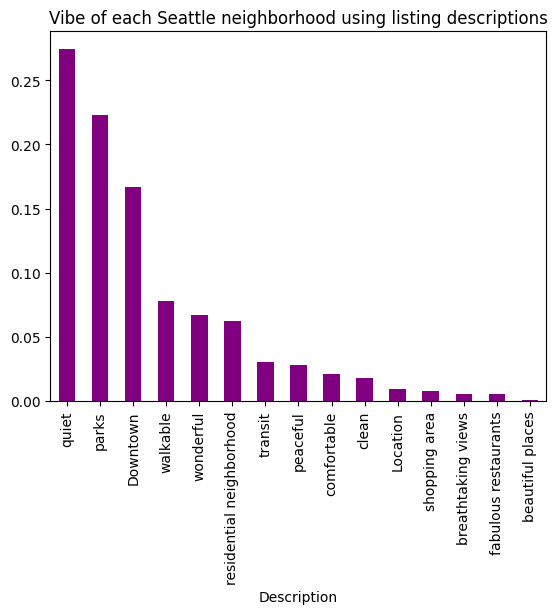

In [32]:
possible_vals = ["peaceful", "residential neighborhood", "wonderful", "breathtaking views",
                 "Downtown", "beautiful places", "fabulous restaurants", "nighlife",
                 "walkable", "parks", "clean", "shopping area", "quiet", "Location", "transit",
                 "comfortable"]


def clean_and_plot(df, 
                   title='Vibe of each Seattle neighborhood using listing descriptions', 
                   plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    revs = df["neighborhood_overview"].value_counts().reset_index()
    revs.rename(columns={"neighborhood_overview":"Description", "count":"count"},
                 inplace=True)
    reviews_df = total_count(revs, 'Description', 'count', possible_vals)

    reviews_df.set_index('Description', inplace=True)
    if plot:
        (reviews_df/reviews_df.sum()).plot(kind='bar', legend=None, color='purple');
        plt.title(title);
        plt.show()
    props_review_df = reviews_df/reviews_df.sum()
    return props_review_df
    
props_df = clean_and_plot(df = df_seattle)

From above we can say most of the guests prefer a quite place, followed by localities close to parks and downtown for there stay.  

# Q3: What are the prices of listings in Seattle. By how much do prices spike? What are the maximum, minimum and mean price of the listings?

In [15]:
df_price_demo = pd.DataFrame(data=df_seattle[['price', "neighbourhood"]])
df_price_demo["price_demo_float"] = df_price_demo['price'].replace('[$, ]', "", regex=True).astype(float)
df_price_demo.drop('price', axis=1, inplace=True)
df_price_demo.dropna().head()

,neighbourhood,price_demo_float
0,Queen Anne,85.0
1,Queen Anne,150.0
2,Queen Anne,975.0
3,Queen Anne,100.0
4,Queen Anne,450.0


In [16]:
df_price_demo['price_demo_float'].isnull().mean() > 0.1

False

In [17]:
# find minimum, maximum and average price for listing
min_price = df_price_demo['price_demo_float'].min()
max_price = df_price_demo['price_demo_float'].max()
mean_price = df_price_demo['price_demo_float'].mean()

print('Minimum price per listing is %d$.' % (min_price))
print('Maximum price per listing is %d$' % (max_price))
print('Average price per listing is %d$.' % (mean_price))

Minimum price per listing is 20$.
Maximum price per listing is 1000$
Average price per listing is 127$.


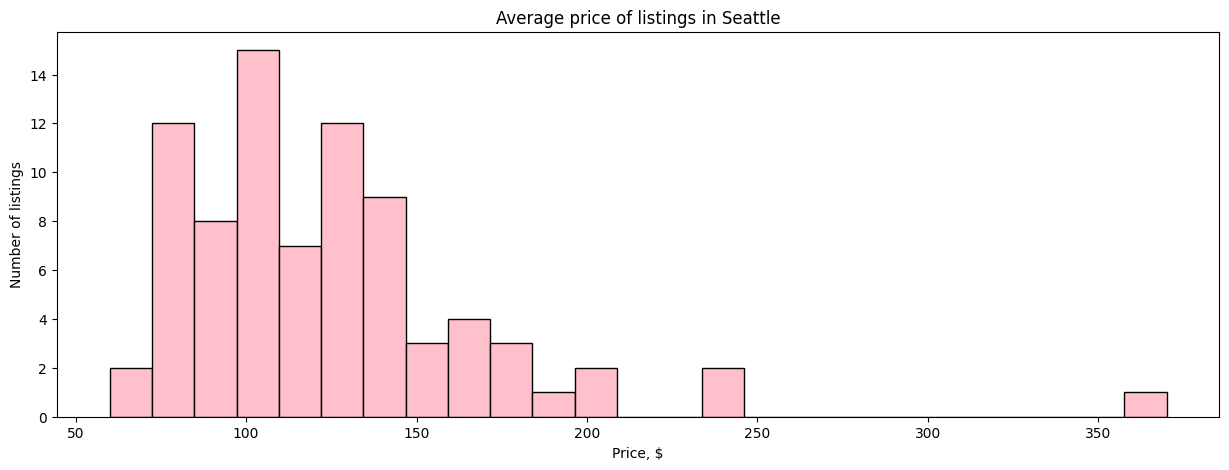

In [35]:
mean_val_seattle = df_price_demo.groupby(['neighbourhood']).mean()['price_demo_float']

plt.figure(figsize=(15,5))
plt.hist(mean_val_seattle, bins=25, color= 'pink', edgecolor='black')
plt.ylabel('Number of listings')
plt.xlabel('Price, $')
plt.title('Average price of listings in Seattle')

# plt.savefig('Price distrubution.png')

plt.show()

The above findings depict that most of the listings are priced around the $100 range. The maximum price for a listing was $1000 and minimum of $20 with a mean of $127.

    
# Q4: How many listings are there per region/neighborhood?

In [19]:
# turn off SettingWithCopyWarning
pd.set_option('chained', None)

In [20]:
# np.sum(get_dollar(df_seattle['price']).isnull()) == 0  #True
print(get_dollar(df_seattle['price']).head(2))

0     85.0
1    150.0
Name: price, dtype: float64


In [21]:
df_cal = df_cal.rename(columns={"listing_id":"id"})
df_cal.head(2)

,id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


Merge calendar and listing dataframe

In [22]:
df_merge = df_seattle.merge(df_cal,
                          on = 'id',
                          how='left')
df_merge.head(1)
# df_merge.columns
# len(df_merge.id.unique())

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,date,available,price_y
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,2016-01-04,t,$85.00


In [23]:
# The percentage of properties by region 
percent_by_region = round(df_merge['neighbourhood_group_cleansed'].value_counts(normalize=True) * 100, 2)
percent_by_region

neighbourhood_group_cleansed
Other neighborhoods    20.80
Capitol Hill           14.85
Downtown               13.88
Central Area            9.66
Queen Anne              7.73
Ballard                 6.02
West Seattle            5.32
Rainier Valley          4.16
University District     3.20
Beacon Hill             3.09
Cascade                 2.33
Northgate               2.10
Delridge                2.07
Lake City               1.75
Magnolia                1.60
Seward Park             1.15
Interbay                0.29
Name: proportion, dtype: float64

<Axes: xlabel='neighbourhood_group_cleansed'>

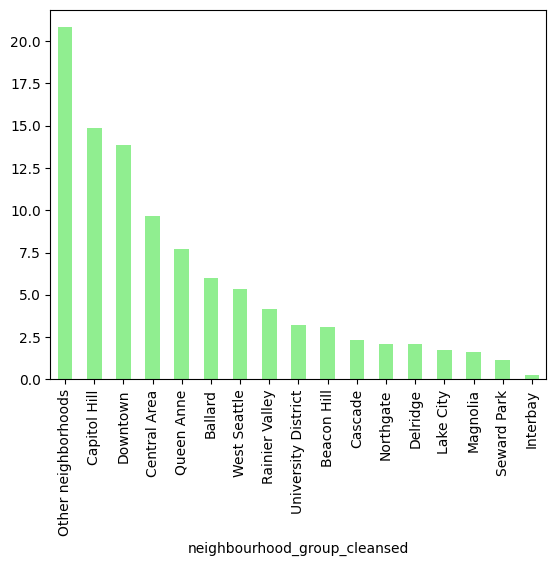

In [38]:
percent_by_region.plot(kind='bar', color='lightgreen')

In [24]:
# Percentage of bookings available...
df_merge['available'].value_counts()/df_merge.shape[0] * 100

available
t    67.061002
f    32.938998
Name: count, dtype: float64

# Q5: Top 10 host with maximum number of bookings?

In [25]:
num_of_booking = pd.DataFrame(
    data=df_merge.groupby(['host_id'])['host_total_listings_count'].mean().sort_values(ascending=False).reset_index()
    )
print(f"Top 10 bookings booked are: {num_of_booking.head(10)}")

Top 10 bookings booked are:     host_id  host_total_listings_count
0  30283594                      502.0
1  31148752                      354.0
2   4962900                      169.0
3    661691                      163.0
4    103427                       84.0
5   8534462                       48.0
6   1243056                       37.0
7    430709                       36.0
8   3074414                       34.0
9     74305                       34.0


# Q6: Most expensive listings based on neighborhood?

In [26]:
df_seattle['price'] = get_dollar(df_seattle['price'])

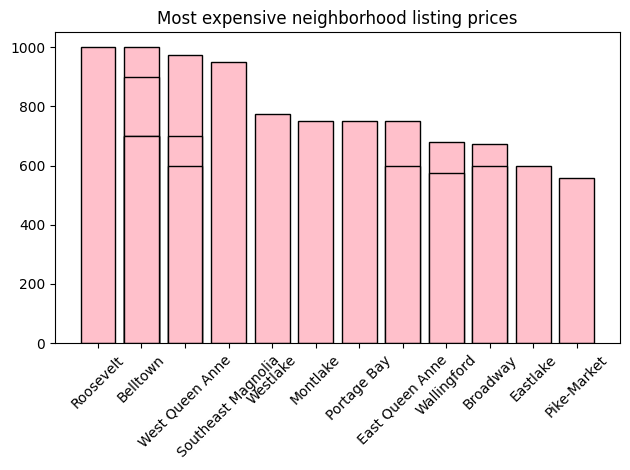

In [27]:
neighborhood_price = df_seattle[['price',
                                 'neighbourhood_cleansed']][df_seattle.price > df_seattle.price.mean()].sort_values(by='price',
                                ascending=False)
# neighborhood_price.head(10)

barplot = plt.bar(data=neighborhood_price.iloc[0:20,:],
            x='neighbourhood_cleansed',
            height='price',
            fc='pink',
            ec='black')
plt.xticks(rotation=45)
plt.title('Most expensive neighborhood listing prices')
plt.tight_layout()

The above graph shows the most expensive listings in the seattle area. 

# The End!